# Início

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm
import time
import os
from scipy import signal
from scipy.signal import find_peaks
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import pickle
import matplotlib.pyplot as plt

In [2]:
with open('Udata.pkl', 'rb') as file:
    Udata = pickle.load(file)

In [3]:
# Vamos remover a atividade 'jumping'
actis = ['climbingdown', 'climbingup', 'lying', 'running', 'sitting', 'standing', 'walking']
posis = ['chest', 'forearm', 'head', 'shin', 'thigh', 'upperarm', 'waist']
users = ['proband' + x for x in np.arange(1,16).astype(str)]
# proband2 não tem acc_climbingup_forearm
users.remove('proband2')
# Vamos remover usuários com menos de 21000 amostras
users.remove('proband1')
users.remove('proband4')
users.remove('proband7')
users.remove('proband14')

In [4]:
# Udata está organizado como [usuario][posicao][atividade][tempo][dims]
Dtr = np.array(Udata[5][0])[:, :11000, :]
Xtr = Dtr.reshape(-1).reshape(770, 600)

In [5]:
Xtr.shape

(770, 600)

In [6]:
Dtr.shape

(7, 11000, 6)

In [7]:
px.line(Dtr[2])

In [8]:
def plotCR(X):
    N = X.shape[0]
    L = N*(N-1)//2
    rx = np.zeros(L)
    cont = 0
    for i in range(N-1):
        for j in range(i+1,N):
            rx[cont] = max(abs(X[i,:]-X[j,:]))*2
            cont += 1
    rx = np.sort(rx)
    ex = np.log2(rx)
    ey = np.log2(np.arange(1,L+1)/L)
    # px.scatter(x=ex,y=ey)
    plt.plot(ex,ey)
    return ex, ey

(array([-2.07694535, -1.95135311, -1.79116185, ...,  5.38693034,
         5.47316415,  5.50458398]),
 array([-1.86259585e+01, -1.76259585e+01, -1.70409960e+01, ...,
        -7.13236241e-06, -3.56617680e-06,  0.00000000e+00]))

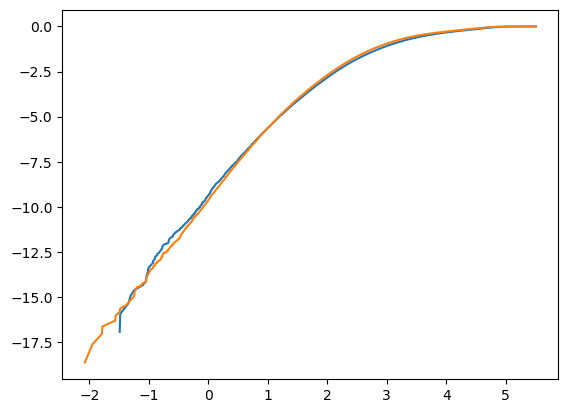

In [9]:
X = np.array(Udata[5][0])[0, 1500:2000, :]
ex, ey = plotCR(X)
X = np.array(Udata[5][0])[0, 1500:2400, :]
plotCR(X)

# Exploração de métodos de análise do plotCR

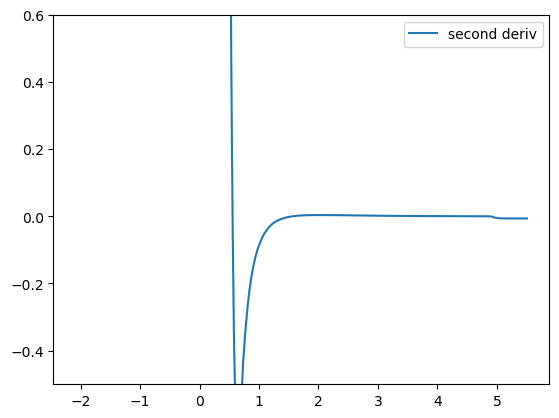

In [68]:
# calculate second order deriv.
y_conv = np.convolve(ey, y1, mode="same")

# plot data
plt.plot(ex,y_conv, label = "second deriv")
# plt.plot(ex, ey,"o", label = "noisy data")
# plt.hlines([0],-10, 20)
# plt.axvspan(0,4, color="y", alpha=0.2)
# plt.axvspan(6,14, color="y", alpha=0.2)
# plt.axhspan(-1,1, color="b", alpha=0.2)
# plt.vlines([0, 4, 6],-10, 10)
# plt.xlim(-2.5,12)
plt.ylim(-0.5,0.6)
plt.legend(loc=0)
plt.show()

In [52]:
# create theoretical data
x_a = np.linspace(-8,0, 60)
y_a = np.sin(x_a)
x_b = np.linspace(0,4,30)[1:]
y_b = x_b[:]
x_c = np.linspace(4,6,15)[1:]
y_c = np.sin((x_c - 4)/4*np.pi)/np.pi*4. + 4
x_d = np.linspace(6,14,120)[1:]
y_d = np.zeros(len(x_d)) + 4 + (4/np.pi)

x = np.concatenate((x_a, x_b, x_c, x_d))
y = np.concatenate((y_a, y_b, y_c, y_d))


# make noisy data from theoretical data
y_n = y + np.random.normal(0, 0.27, len(x))

# create convolution kernel for calculating
# the smoothed second order derivative
smooth_width = 59
x1 = np.linspace(-3,3,smooth_width)
norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])

In [66]:
smooth_width = 10000
x1 = np.linspace(-3,3,smooth_width)
norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])
px.line(x=x1,y=y1)

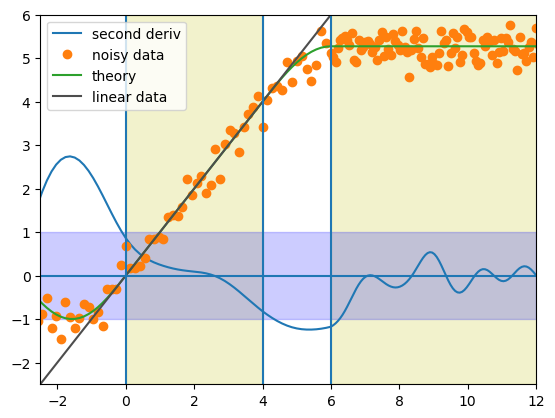

In [53]:
# calculate second order deriv.
y_conv = np.convolve(y_n, y1, mode="same")

# plot data
plt.plot(x,y_conv, label = "second deriv")
plt.plot(x, y_n,"o", label = "noisy data")
plt.plot(x, y, label="theory")
plt.plot(x, x, "0.3", label = "linear data")
plt.hlines([0],-10, 20)
plt.axvspan(0,4, color="y", alpha=0.2)
plt.axvspan(6,14, color="y", alpha=0.2)
plt.axhspan(-1,1, color="b", alpha=0.2)
plt.vlines([0, 4, 6],-10, 10)
plt.xlim(-2.5,12)
plt.ylim(-2.5,6)
plt.legend(loc=0)
plt.show()

In [ ]:
from scipy import optimize

In [9]:
import piecewise_regression

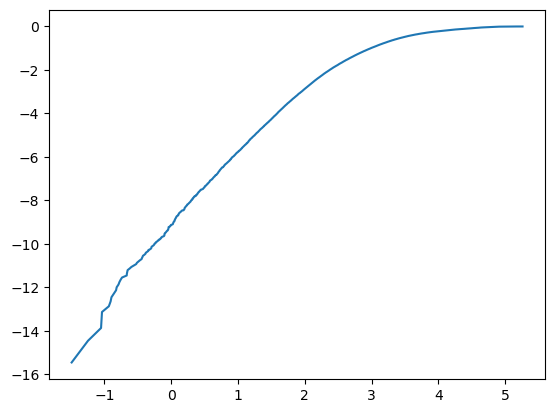

In [13]:
X = np.array(Udata[5][0])[0, 1700:2000, :]
ex, ey = plotCR(X)

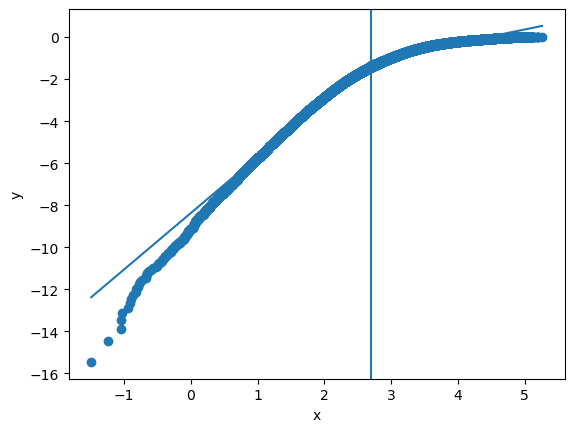

In [15]:
pw_fit = piecewise_regression.Fit(ex, ey, n_breakpoints=1)
pw_fit.plot()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [69]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15], dtype=float)
y = np.array([5, 7, 9, 11, 13, 15, 28.92, 42.81, 56.7, 70.59, 84.47, 98.36, 112.25, 126.14, 140.03])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p = piecewise_linear
p

<function __main__.piecewise_linear(x, x0, y0, k1, k2)>

In [70]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

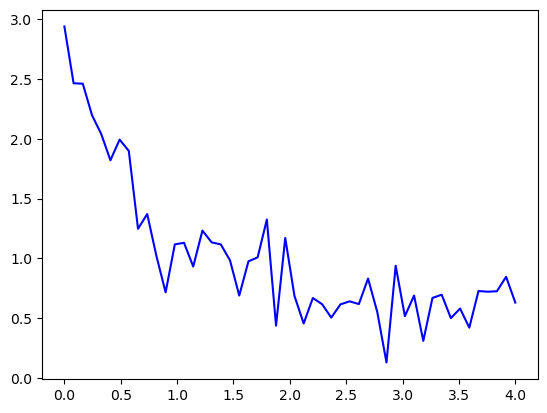

In [71]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
rng = np.random.default_rng()
y_noise = 0.2 * rng.normal(size=xdata.size)
ydata = y + y_noise
plt.plot(xdata, ydata, 'b-', label='data')

In [72]:
from scipy.optimize import curve_fit

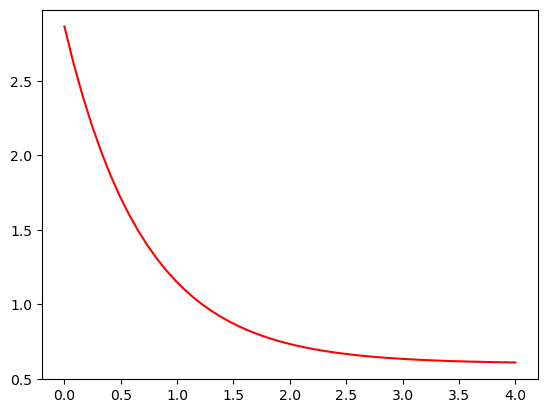

In [73]:
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

# Método de Luizinho

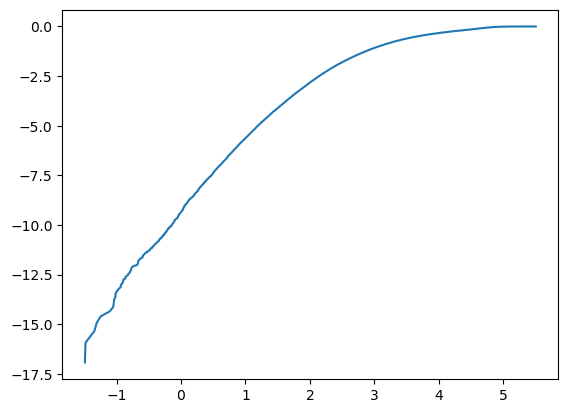

In [10]:
X = np.array(Udata[5][0])[0, 1500:2000, :]
ex, ey = plotCR(X)

In [13]:
from sklearn.linear_model import LinearRegression

In [20]:
regre = LinearRegression().fit(ex.reshape(-1, 1), ey)

In [22]:
regre.score(ex.reshape(-1, 1), ey)

0.8402409602044287

In [26]:
b = regre.intercept_
a = regre.coef_
a, b

(array([1.32226288]), -5.516672990627428)

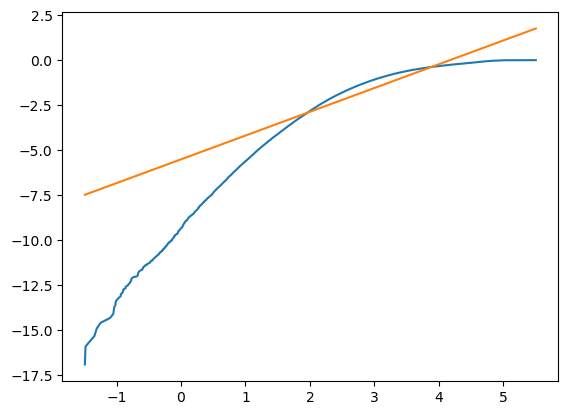

In [25]:
plt.plot(ex,ey)
plt.plot([min(ex), max(ex)], [min(ex), max(ex)]*a+b)

In [33]:
limi = min(ex)+(max(ex)-min(ex))/3
lims = max(ex)-(max(ex)-min(ex))/3
ni = np.argmin(abs(ex-limi))
ns = np.argmin(abs(ex-lims))
limi, lims

(0.8402475388997956, 3.1724157569580167)

In [34]:
regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
b = regre.intercept_
a = regre.coef_
a, b

(array([2.06330916]), -7.103007163010476)

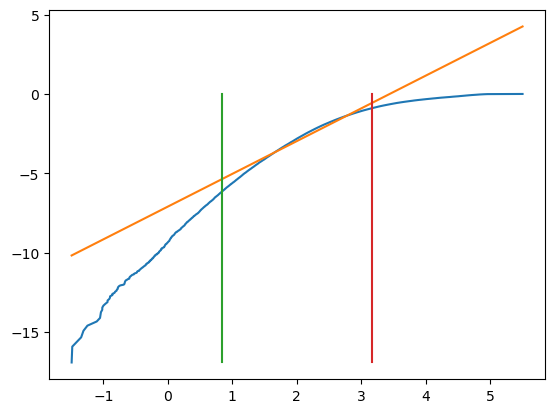

In [37]:
plt.plot(ex,ey)
plt.plot([min(ex), max(ex)], [min(ex), max(ex)]*a+b)
plt.plot([limi, limi],[min(ey),max(ey)])
plt.plot([lims, lims],[min(ey),max(ey)])

0.9966300340723826 0 1746
0.9746735546951372 1746 67210
0.9658636695117153 67210 124749


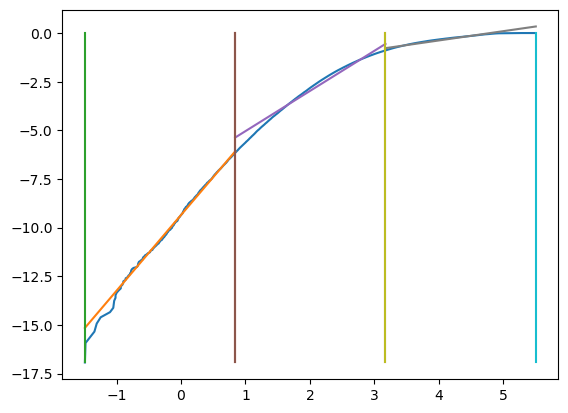

In [57]:
k = 3
faixa = (max(ex)-min(ex))/k
plt.plot(ex,ey)
for i in range(k):
    limi = min(ex)+faixa*i
    lims = min(ex)+faixa*(i+1)
    ni = np.argmin(abs(ex-limi))
    ns = np.argmin(abs(ex-lims))
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    b = regre.intercept_
    a = regre.coef_
    print(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]), ni, ns)
    plt.plot([ex[ni], ex[ns]], [ex[ni], ex[ns]]*a+b)
    plt.plot([limi, limi],[min(ey),max(ey)])
    plt.plot([lims, lims],[min(ey),max(ey)])

0.9960005892719275 0 894
0.9978036685221494 5 2416
0.9966033695578286 31 5833
0.9940626224191298 88 12539
0.9928393148567838 311 24465
0.9888380323980295 894 41222
0.9808274239736507 2416 60713
0.9702394151725173 5833 79588
0.9581370324169047 12539 94917
0.9465477704540434 24465 106774
0.940199714066378 41222 118032
0.9578054052751716 60713 124598
0.9816018801869152 79588 124749


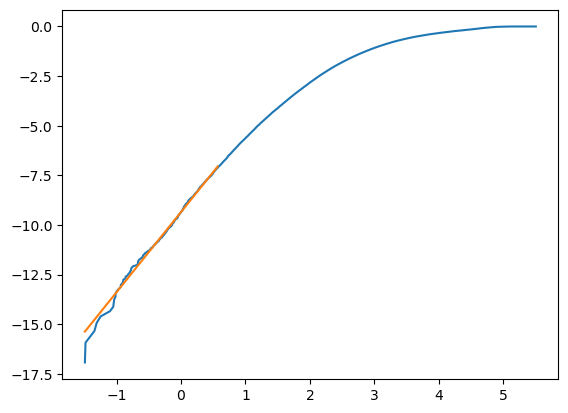

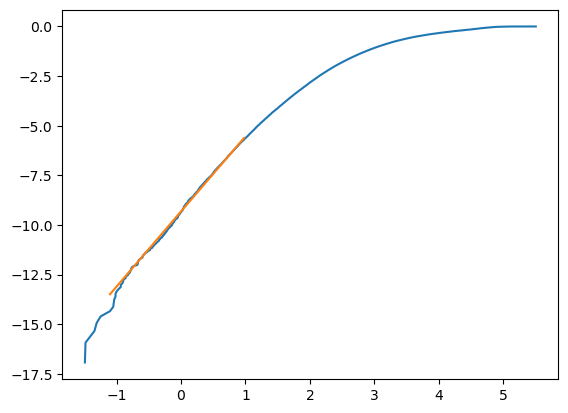

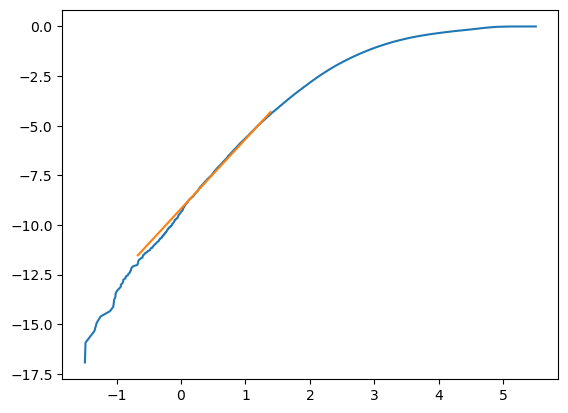

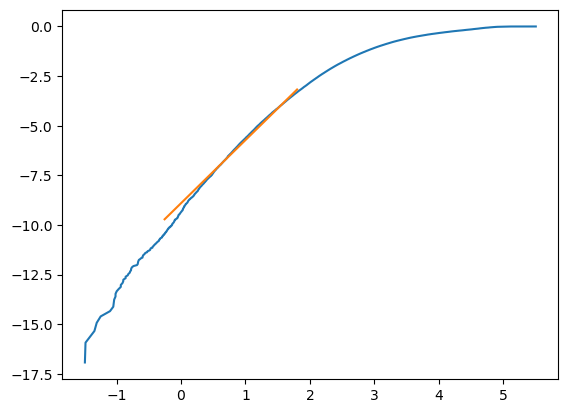

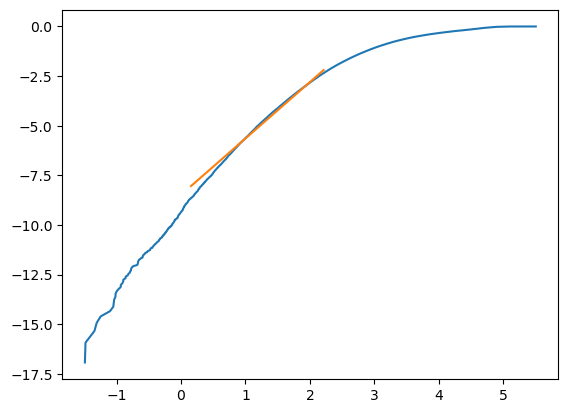

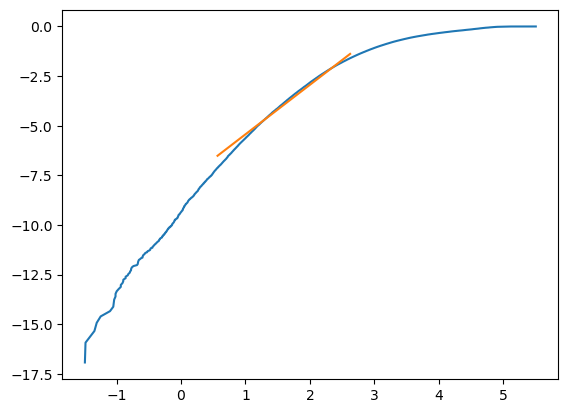

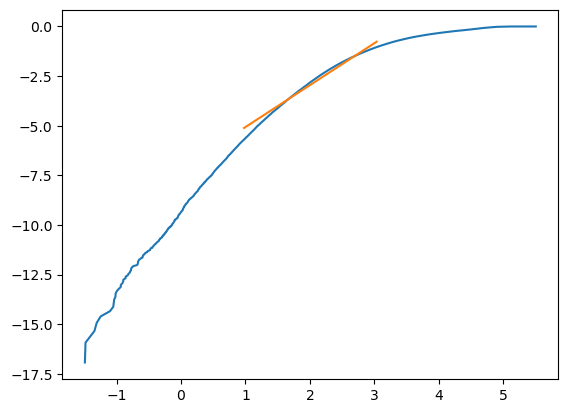

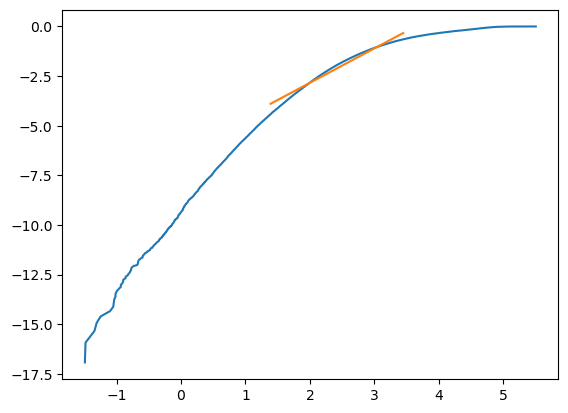

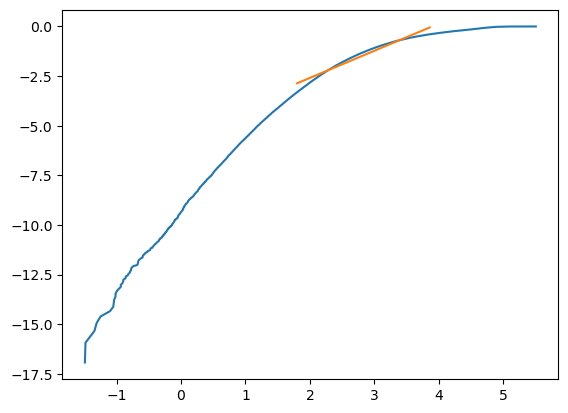

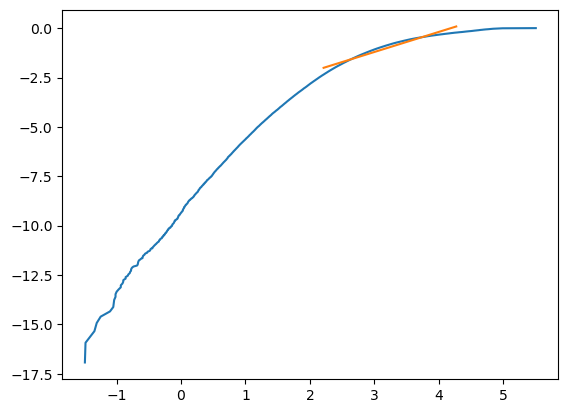

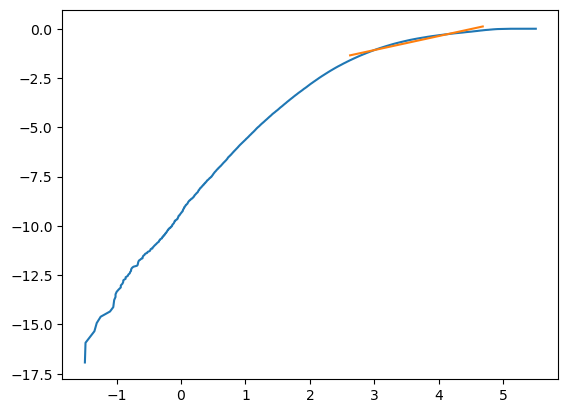

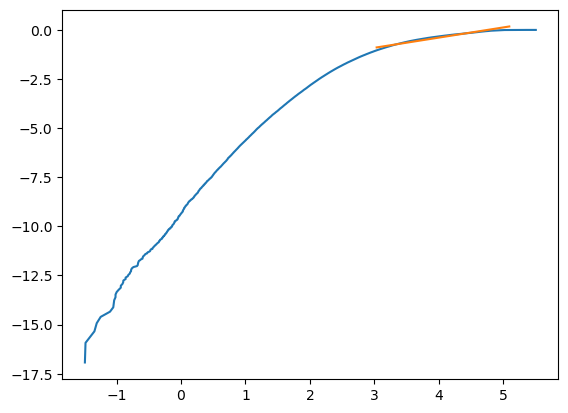

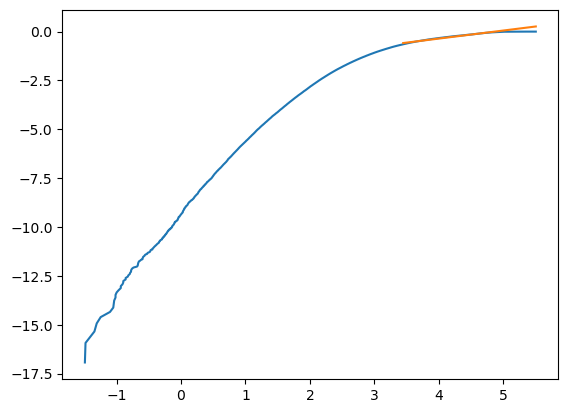

In [65]:
k = 17
janela = 5
faixa = (max(ex)-min(ex))/k
for i in range(k-janela+1):
    limi = min(ex)+faixa*i
    lims = min(ex)+faixa*(i+janela)
    ni = np.argmin(abs(ex-limi))
    ns = np.argmin(abs(ex-lims))
    regre = LinearRegression().fit(ex[ni:ns].reshape(-1, 1), ey[ni:ns])
    b = regre.intercept_
    a = regre.coef_
    print(regre.score(ex[ni:ns].reshape(-1, 1), ey[ni:ns]), ni, ns)
    plt.figure(i+1)
    plt.plot(ex,ey)
    plt.plot([ex[ni], ex[ns]], [ex[ni], ex[ns]]*a+b)
    # plt.plot([limi, limi],[min(ey),max(ey)])
    # plt.plot([lims, lims],[min(ey),max(ey)])